# 机器学习第4章练习-决策树


1．分类决策树模型是表示基于特征对实例进行分类的树形结构。决策树可以转换成一个**if-then**规则的集合，也可以看作是定义在特征空间划分上的类的条件概率分布。

2．决策树学习旨在构建一个与训练数据拟合很好，并且复杂度小的决策树。因为从可能的决策树中直接选取最优决策树是NP完全问题。现实中采用启发式方法学习次优的决策树。

决策树学习算法包括3部分：特征选择、树的生成和树的剪枝。常用的算法有ID3、
C4.5和CART。

3．特征选择的目的在于选取对训练数据能够分类的特征。特征选择的关键是其准则。常用的准则如下：

（1）样本集合$D$对特征$A$的信息增益（ID3）


$$g(D, A)=H(D)-H(D|A)$$

$$H(D)=-\sum_{k=1}^{K} \frac{\left|C_{k}\right|}{|D|} \log _{2} \frac{\left|C_{k}\right|}{|D|}$$

$$H(D | A)=\sum_{i=1}^{n} \frac{\left|D_{i}\right|}{|D|} H\left(D_{i}\right)$$

其中，$H(D)$是数据集$D$的熵，$H(D_i)$是数据集$D_i$的熵，$H(D|A)$是数据集$D$对特征$A$的条件熵。	$D_i$是$D$中特征$A$取第$i$个值的样本子集，$C_k$是$D$中属于第$k$类的样本子集。$n$是特征$A$取 值的个数，$K$是类的个数。

（2）样本集合$D$对特征$A$的信息增益比（C4.5）


$$g_{R}(D, A)=\frac{g(D, A)}{H(D)}$$


其中，$g(D,A)$是信息增益，$H(D)$是数据集$D$的熵。

（3）样本集合$D$的基尼指数（CART）

$$\operatorname{Gini}(D)=1-\sum_{k=1}^{K}\left(\frac{\left|C_{k}\right|}{|D|}\right)^{2}$$

特征$A$条件下集合$D$的基尼指数：

 $$\operatorname{Gini}(D, A)=\frac{\left|D_{1}\right|}{|D|} \operatorname{Gini}\left(D_{1}\right)+\frac{\left|D_{2}\right|}{|D|} \operatorname{Gini}\left(D_{2}\right)$$
 
4．决策树的生成。通常使用信息增益最大、信息增益比最大或基尼指数最小作为特征选择的准则。决策树的生成往往通过计算信息增益或其他指标，从根结点开始，递归地产生决策树。这相当于用信息增益或其他准则不断地选取局部最优的特征，或将训练集分割为能够基本正确分类的子集。

5．决策树的剪枝。由于生成的决策树存在过拟合问题，需要对它进行剪枝，以简化学到的决策树。决策树的剪枝，往往从已生成的树上剪掉一些叶结点或叶结点以上的子树，并将其父结点或根结点作为新的叶结点，从而简化生成的决策树。


In [1]:
import numpy as np
import pandas as pd
import math
from math import log
from sklearn.metrics import accuracy_score
import re

### 读取数据，课本上西瓜数据

In [2]:
# path = '../数据集合/watermelon2.0.txt'
path = 'id3.csv'
data = pd.read_csv(path)
data.head()

FileNotFoundError: [Errno 2] No such file or directory: 'id3.csv'

In [ ]:
# train_data = data.drop(['编号'],axis=1)
train_data=data
train_data.head()

# train_data.loc[train_data[opt_attr_name] ==f].drop([opt_attr_name], axis=1)

,年龄,有工作,有房子,信用,类别
0,青年,否,否,一般,否
1,青年,否,否,好,否
2,青年,是,否,好,是
3,青年,是,是,一般,是
4,青年,否,否,一般,否


## 计算数据集的熵

$$H(D)=-\sum_{k=1}^{K} \frac{\left|C_{k}\right|}{|D|} \log _{2} \frac{\left|C_{k}\right|}{|D|}$$

其中，$H(D)$是数据集$D$的熵，$|C_k|$是$D$中属于第$k$类的样本个数，$K$是类的个数。

In [ ]:
from collections import Counter

def calcEnt(y_label):
    num_samples = y_label.shape[0]
    cnt = Counter(y_label) ## return a dictionary
    ent = -sum([(p / num_samples) * log(p / num_samples, 2) for p in cnt.values()])
    return ent

## 计算给定某个特征属性后的条件熵

$$H(D | A)=\sum_{i=1}^{n} \frac{\left|D_{i}\right|}{|D|} H\left(D_{i}\right)$$

其中，$D_i$是$D$中特征$A$取第$i$个值的样本子集，$H(D_i)$是数据集$D_i$的熵，$H(D|A)$是数据集$D$对特征$A$的条件熵，$n$是特征$A$取 值的个数。$H(D_i)$的表达式如下：

$$H(D_i)=-\sum_{k=1}^{K} \frac{\left|C_{k}^i\right|}{|D_i|} \log _{2} \frac{\left|C_{k}^i\right|}{|D_i|}$$

其中$|D_i|$为属性A取第$i$个取值时的样本个数，$|C_{k}^i|$为样本集$D_i$中属于第$k$个类别的个数。

In [ ]:
def condEnt(attri_data, y_label):
    num_samples = y_label.shape[0]
    attri_cnt = Counter(attri_data) ## return a dictionary
    cond_ent = 0
    for key in attri_cnt:
        attri_key_label = y_label[attri_data==key]
        cond_ent += len(attri_key_label)/num_samples * calcEnt(attri_key_label)
    return cond_ent

## 计算信息增益 

给定特征属性$A$后，信息增益$g(D, A)$定义为原有数据的信息熵H(D)减去条件信息熵H(D|A)

$$g(D, A)=H(D)-H(D|A)$$

## 选择特征属性

信息增益最大的属性被选择。

In [ ]:
def OptAttri(train_data):
    infoGain =0
    y_label = train_data.iloc[:,-1]
    attri_num = train_data.shape[1]-1
    for i in range (attri_num):
        attri_data = train_data.iloc[:,i]
        ent = calcEnt(y_label)
        cond_ent = condEnt(attri_data, y_label)
        infoGain_tmp = ent-cond_ent
        if infoGain_tmp > infoGain:
            infoGain = infoGain_tmp
            opt_attr_name = train_data.columns[i]
            opt_attr = i
    return opt_attr, opt_attr_name, infoGain


In [ ]:
# opt_name, infG = OptAttri(train_data)
# print ('特征({})的信息增益最大，其值为({})，选择为根节点特征.'.format(opt_name,infG))

## 定义节点类

* 一个节点，应该包含节点的属性，节点标签，节点子属性，节点预测
* 若节点是根节点，则直接给节点属性和节点标签
* 若节点不是根节点，则需要对节点进行继续划分，需要构建树

In [ ]:
# 定义节点类 二叉树
class Node:
    def __init__(self, root=True, label=None, attri_name=None):
        self.root = root ## 是否为根节点
        self.label = label ## 节点的标签
        self.attri_name = attri_name ## 节点的属性名字
        self.tree = {} ## 某个节点的子树
        self.result = {
            'label:': self.label,
            'attri_name':self.attri_name,
            'tree': self.tree,
            'root': self.root
        }
    def add_node(self, val, node): ## 根据属性的划分取值val，继续建立节点。
        self.tree[val] = node

    def __repr__(self):
        return '{}'.format(self.result)


In [ ]:
from pydotplus import graphviz
import re
from IPython.display import display, Image

def tree2graph(i, g, root):
    if root.attri_name == None:
        g_node_label = f'Node:{i}\n属性:{root.attri_name}\n标签:{root.label}'
    else:
        g_node_label = f'Node:{i}\n属性:{root.attri_name}\n标签:{root.label}'
    g_node = i
    g.add_node(graphviz.Node(g_node, label=g_node_label, fontname='FangSong'))

    for val in list(root.tree):
        i, g_children = tree2graph(i+1, g, root.tree[val])
        g.add_edge(graphviz.Edge(g_node, g_children, label=val, fontname='FangSong'))
    return i, g_node

def draw(root):
    g = graphviz.Dot()
    tree2graph(0, g, root)
    g2 = graphviz.graph_from_dot_data(g.to_string())
    display(Image(g2.create_png()))

## 利用ID3算法建立decision tree

In [ ]:
class ID3_DTree:
    def __init__(self, epsilon=0.1):
        self.epsilon = epsilon
        self._tree = {}

    # 熵
    def calcEnt(self, y_label):
        num_samples = y_label.shape[0]
        cnt = Counter(y_label) ## return a dictionary
        ent = -sum([(p / num_samples) * log(p / num_samples, 2) for p in cnt.values()])
        return ent


    # 条件熵

    def condEnt(self, attri_data, y_label):
        num_samples = y_label.shape[0]
        attri_cnt = Counter(attri_data) ## return a dictionary
        cond_ent = 0
        for key in attri_cnt:
            attri_key_label = y_label[attri_data==key]
            cond_ent += len(attri_key_label)/num_samples * self.calcEnt(attri_key_label)
        return cond_ent

    ## 特征属性选择

    def OptAttri(self,train_data):
        infoGain =0
        y_label = train_data.iloc[:,-1]
        attri_num = train_data.shape[1]-1
        for i in range (attri_num):
            attri_data = train_data.iloc[:,i]
            ent = self.calcEnt(y_label)
            cond_ent = self.condEnt(attri_data, y_label)
            infoGain_tmp = ent-cond_ent
            if infoGain_tmp > infoGain:
                infoGain = infoGain_tmp
                opt_attr = train_data.columns[i] ## attri name
        return opt_attr, infoGain

    def train(self, train_data):
        """
        input:数据集D(DataFrame格式)，特征集A，阈值eta
        output:决策树T
        """
        y_label = train_data.iloc[:,-1]
        feature_space = train_data.columns[:-1] ## feature names

        features = train_data.iloc[:,:-1]

        # 1,若D中实例属于同一类Ck，即y_label 中的类别个数为1，则T为单节点树，并将类Ck作为结点的类标记，返回T
        if len(y_label.value_counts()) == 1:
            return Node(root=True, label=y_label.iloc[0])

        # 2, 若特征属性A为空，则T为单节点树，将D中样本数最多的类Ck作为该节点的类标记，返回T
        if len(feature_space) == 0:
            return Node(root=True,label=y_label.value_counts().sort_values(ascending=False).index[0])

        # 3,若不是上述情况，需要计算信息增益, 选择信息增益最大的属性做为待选根节点属性Ag
        opt_attr_name, max_infoGain= self.OptAttri(train_data)

        # 4,若Ag的信息增益小于阈值eta,则置T为单节点树，并将D中是样本数最多的类Ck作为该节点的类标记，返回T
        if max_infoGain < self.epsilon:
            return Node(root=True,label=y_train.value_counts().sort_values(ascending=False).index[0])

        # 5,若Ag的infogain大于阈值eta，则需要构建Ag子集
        node_tree = Node(root=False, attri_name=opt_attr_name)
        feature_list = train_data[opt_attr_name].value_counts().index ## 已选属性的子属性的名称

         ## 需要确定每个子属性下面的样本子集，并且根据其他属性对样本子集继续进行树的划分 （去除根属性）
        for f in feature_list:
            sub_train_df = train_data.loc[train_data[opt_attr_name] ==f].drop([opt_attr_name], axis=1)

         # 6, 递归生成树：对样本子集继续进行树的划分
            sub_tree = self.train(sub_train_df)
            node_tree.add_node(f, sub_tree)
        return node_tree

    def fit(self, train_data):
        Dtree = self.train(train_data)
        return Dtree


    def predict(self, root, test_data_Frame): ## test_data_Frame （针对西瓜例子，没有编号这个属性）, root 是建立好的树
        root0= root
        testNum = test_data_Frame.shape[0]
        pred=[]
        for i in range(testNum):
            root = root0
            test_data = test_data_Frame.iloc[i:i+1,:]

            while root.attri_name!=None: ## 说明根节点可以划分
                attri_val = test_data[root.attri_name].values[0] # 根节点的属性取值
                if attri_val in root.tree: # 若存在子树，则将此时的属性节点当成根节点，直到不能划分时，即为叶节点
                    root = root.tree[attri_val]
                else:
                    break
            y_pred = root.label
            pred.append(y_pred)
        return pred





## C4.5 按照信息增益率选择特征属性

In [ ]:
def calcIV(attri_data):
    num_samples = attri_data.shape[0]
    attri_cnt = Counter(attri_data) ## return a dictionary
    IV = 0
    for key in attri_cnt:
        IV += -attri_cnt[key]/ num_samples * np.log2(attri_cnt[key] / num_samples)
    return IV

In [ ]:
attri_data = train_data.iloc[:,2]
calcIV(attri_data)

0.9709505944546686

In [ ]:
class C45_DTree:
    def __init__(self, epsilon=0.1):
        self.epsilon = epsilon
        self._tree = {}

    # 熵
    def calcEnt(self, y_label):
        num_samples = y_label.shape[0]
        cnt = Counter(y_label) ## return a dictionary
        ent = -sum([(p / num_samples) * log(p / num_samples, 2) for p in cnt.values()])
        return ent


    # 条件熵

    def condEnt(self, attri_data, y_label):
        num_samples = y_label.shape[0]
        attri_cnt = Counter(attri_data) ## return a dictionary
        cond_ent = 0
        for key in attri_cnt:
            attri_key_label = y_label[attri_data==key]
            cond_ent += len(attri_key_label)/num_samples * self.calcEnt(attri_key_label)
        return cond_ent

    ## 固有属性
    def calcIV(self,attri_data):
        num_samples = attri_data.shape[0]
        attri_cnt = Counter(attri_data) ## return a dictionary
        IV = 0
        for key in attri_cnt:
            IV += -attri_cnt[key]/ num_samples * np.log2(attri_cnt[key] / num_samples)
        return IV

       ## 根据信息增益率选择特征属性
    def OptAttri_gain_ratio_origin(self, train_data):
        gain_ratio =0
        y_label = train_data.iloc[:,-1]
        attri_num = train_data.shape[1]-1
        Info = 0

        for i in range (attri_num):
            attri_data = train_data.iloc[:,i]
            ent = self.calcEnt(y_label)
            cond_ent = self.condEnt(attri_data, y_label)
            IV = self.calcIV(attri_data)
            infoGain = ent-cond_ent

            gain_ratio_tmp = infoGain/IV
            if gain_ratio_tmp > gain_ratio:
                gain_ratio = gain_ratio_tmp
                opt_attr_name = train_data.columns[i]
        return opt_attr_name, gain_ratio

    ## 根据信息增益率选择特征属性
    def OptAttri_gain_ratio(self, train_data):
        gain_ratio =0
        y_label = train_data.iloc[:,-1]
        attri_num = train_data.shape[1]-1
        Info = 0
        ## calculate the average info_gain
        Info_Gain=[]
        for i in range (attri_num):
            attri_data = train_data.iloc[:,i]
            ent = self.calcEnt(y_label)
            print(f"{data.columns[i]} {ent=}")
            cond_ent = self.condEnt(attri_data, y_label)
            print(f"{data.columns[i]} {cond_ent=}")
            infoGain = ent-cond_ent
            Info_Gain.append(infoGain)
            Info += infoGain
        Avg_gain = Info/attri_num
        print(f"{data.columns[i]} {Avg_gain=}")
        all_attri = train_data.iloc[:,:-1]
        attri_D = all_attri.iloc[:,np.asarray(Info_Gain)>=Avg_gain ]
        InfoGain_D = np.asarray(Info_Gain)[np.asarray(Info_Gain)>=Avg_gain]

        for j in range (attri_D.shape[1]):
            attri_data = attri_D.iloc[:,j]
            gain_D = InfoGain_D[j]
            IV = self.calcIV(attri_data)
            gain_ratio_tmp = gain_D/IV

            if gain_ratio_tmp > gain_ratio:
                gain_ratio = gain_ratio_tmp
                opt_attr_name = attri_D.columns[j]
        return opt_attr_name, gain_ratio

    def train(self, train_data):
        """
        input:数据集D(DataFrame格式)，特征集A，阈值eta
        output:决策树T
        """
        y_label = train_data.iloc[:,-1]
        feature_space = train_data.columns[:-1] ## feature names
        features = train_data.iloc[:,:-1]

        # 1,若D中实例属于同一类Ck，即y_label 中的类别个数为1，则T为单节点树，并将类Ck作为结点的类标记，返回T
        if len(y_label.value_counts()) == 1:
            return Node(root=True, label=y_label.iloc[0])

        # 2, 若特征属性A为空，则T为单节点树，将D中样本数最多的类Ck作为该节点的类标记，返回T
        if len(feature_space) == 0:
            return Node(root=True,label=y_label.value_counts().sort_values(ascending=False).index[0])

        # 3,若不是上述情况，需要计算信息增益, 选择信息增益最大的属性做为待选根节点属性Ag
        opt_attr_name, max_infoGain= self.OptAttri_gain_ratio(train_data)
#         opt_attr_name, max_infoGain= self.OptAttri_gain_ratio_origin(train_data)

        # 4,若Ag的信息增益小于阈值eta,则置T为单节点树，并将D中是样本数最多的类Ck作为该节点的类标记，返回T
        if max_infoGain < self.epsilon:
            return Node(root=True,label=y_train.value_counts().sort_values(ascending=False).index[0])

        # 5,若Ag的infogain大于阈值eta，则需要构建Ag子集
        node_tree = Node(root=False, attri_name=opt_attr_name)
        feature_list = train_data[opt_attr_name].value_counts().index ## 已选属性的子属性的名称

         ## 需要确定每个子属性下面的样本子集，并且根据其他属性对样本子集继续进行树的划分 （去除根属性）
        for f in feature_list:
            sub_train_df = train_data.loc[train_data[opt_attr_name] ==f].drop([opt_attr_name], axis=1)
#             print (sub_train_df)

         # 6, 递归生成树：对样本子集继续进行树的划分
            sub_tree = self.train(sub_train_df)
            node_tree.add_node(f, sub_tree)
        return node_tree

    def fit(self, train_data):
        Dtree = self.train(train_data)
        return Dtree


    def predict(self, root, test_data_Frame): ## test_data_Frame （针对西瓜例子，没有编号这个属性）, root 是建立好的树
        root0= root
        testNum = test_data_Frame.shape[0]
        pred=[]
        for i in range(testNum):
            root = root0
            test_data = test_data_Frame.iloc[i:i+1,:]

            while root.attri_name!=None: ## 说明根节点可以划分
                attri_val = test_data[root.attri_name].values[0] # 根节点的属性取值
                if attri_val in root.tree: # 若存在子树，则将此时的属性节点当成根节点，直到不能划分时，即为叶节点
                    root = root.tree[attri_val]
                else:
                    break
            y_pred = root.label
            pred.append(y_pred)
        return pred

年龄 ent=0.9967916319816366
年龄 cond_ent=0.9709505944546685
有工作 ent=0.9967916319816366
有工作 cond_ent=0.5875272661537951
有房子 ent=0.9967916319816366
有房子 cond_ent=0.45852270390517214
信用 ent=0.9967916319816366
信用 cond_ent=0.6406426982957875
信用 Avg_gain=0.33238081627928073
年龄 ent=0.7642045065086203
年龄 cond_ent=0.6666666666666666
有工作 ent=0.7642045065086203
有工作 cond_ent=0.0
有房子 ent=0.7642045065086203
有房子 cond_ent=0.3605680553151701
有房子 Avg_gain=0.4217929325146747


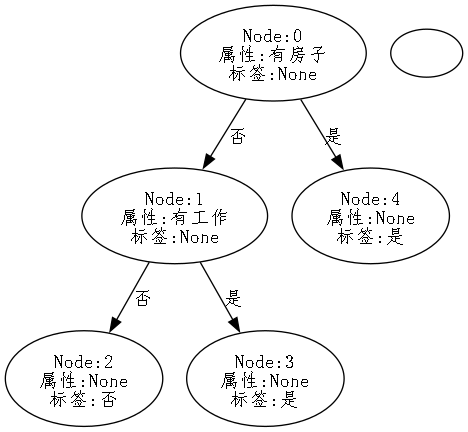

['否', '是', '是', '否', '否', '否', '是', '是', '是', '是', '是']


In [ ]:
# 拟合决策树
dt = C45_DTree()
Dtree = dt.fit(train_data)

# 画树的结构
draw(Dtree)
test_data = train_data.iloc[1:12,:-1]

# # 预测结果
y_pred = dt.predict(Dtree,test_data)
print (y_pred)

## 利用二叉树的思想来构建ID3决策树
#即需要对离散特征属性进行左右划分


In [ ]:
## 把特征属性专成数字
# path ='/Users/lihuiwang/Desktop/王丽会教学/王丽会-机器学习-课件/code/watermelon2.0.txt'
path = r'..\数据集合\watermelon2.0.txt'
data = pd.read_csv(path)
train_data = data.drop(['编号'],axis=1)

df = train_data
df['色泽']=df['色泽'].map({'浅白':1,'青绿':2,'乌黑':3})
df['根蒂']=df['根蒂'].map({'稍蜷':1,'蜷缩':2,'硬挺':3})
df['敲声']=df['敲声'].map({'清脆':1,'浊响':2,'沉闷':3})
df['纹理']=df['纹理'].map({'清晰':1,'稍糊':2,'模糊':3})
df['脐部']=df['脐部'].map({'平坦':1,'稍凹':2,'凹陷':3})
df['触感']=df['触感'].map({'硬滑':1,'软粘':2})
df['好瓜']=df['好瓜'].map({'是':1,'否':0})

In [ ]:
class DTree_binary:
    def __init__(self, method= 'ID3', prune = None, epsilon=0.001):
        self.epsilon = epsilon
        self._tree = {}
        self.method = method
        self.prune = prune
        self.tree_list=[]

    # 熵
    def calcEnt(self, y_label):
        num_samples = y_label.shape[0]
        cnt = Counter(y_label) ## return a dictionary
        ent = -sum([(p / num_samples) * log(p / num_samples, 2) for p in cnt.values()])
        return ent


    # 条件熵

    def condEnt(self, attri_data, y_label):
        num_samples = y_label.shape[0]
        attri_cnt = Counter(attri_data) ## return a dictionary
        cond_ent = 0
        for key in attri_cnt:
            attri_key_label = y_label[attri_data==key]
            cond_ent += len(attri_key_label)/num_samples * self.calcEnt(attri_key_label)
        return cond_ent

        ## 固有属性
    def calcIV(self,attri_data):
        num_samples = attri_data.shape[0]
        attri_cnt = Counter(attri_data) ## return a dictionary
        IV = 0
        for key in attri_cnt:
            IV += -attri_cnt[key]/ num_samples * np.log2(attri_cnt[key] / num_samples)
        return IV

     ## 固有属性：分成两类的固有属性
    def calcIV_Binary(self,attri_data,div):
        num_samples = attri_data.shape[0]
        numl = len(attri_data.loc[attri_data<=div])
        numr =len(attri_data.loc[attri_data>div])

        IV = -numl / num_samples * np.log2(numl/ num_samples) -numr/ num_samples * np.log2(numr/ num_samples)
        return IV

    ## 计算GINI 值

    def gini(self,y_label):
        fc = Counter(y_label)
        fp = np.array(list(fc.values()))
        fp = fp / np.sum(fp)
        gini_data = 1 - np.sum(fp ** 2)
        return gini_data

    ## 特征属性选择

    def OptAttri(self,train_data):
        y_label = train_data.iloc[:,-1]
        attri_num = train_data.shape[1]-1
        num_sample = train_data.shape[0]
        FeaturesName = train_data.columns[:-1]

        if self.method == 'ID3': # 二叉树形式进行划分决策树
            Ent = self.calcEnt(y_label)
            infoG = 0
            div_value = 0
            for feature in FeaturesName:

                attri_data = train_data[feature]
                Effective_values = np.sort(np.unique(attri_data.values))


                if Effective_values.shape[0]==1:
                    infoG_tmp = 0
                    div_value_tmp = 0
                else:
                    infoGain = {} ## 记录不同划分点下获得的信息增益
                    for i in range(Effective_values.shape[0]-1):
                        div = (Effective_values[i] + Effective_values[i+1]) / 2
                        label_left = train_data.loc[attri_data<=div,train_data.columns[-1]]
                        label_right = train_data.loc[attri_data>=div,train_data.columns[-1]]
                        cond_ent = self.calcEnt(label_left)*len(label_left)/num_sample + self.calcEnt(label_right)*len(label_right)/num_sample
                        infoGain[div] = Ent-cond_ent
                    div_value_tmp, infoG_tmp = max(infoGain.items(), key=lambda x: x[1])

                if infoG_tmp >= infoG:
                    infoG = infoG_tmp
                    div_value = div_value_tmp
                    opt_attr = feature ## attri name

            return opt_attr,infoG, div_value


        if self.method == 'C4.5': # 二叉树形式进行划分决策树

            Ent = self.calcEnt(y_label)
            gainRatio = 0
            div_value = 0
            InfoG = [] ## 记录每个属性的信息增益
            Divs =[]
            Info = 0
            for feature in FeaturesName:

                attri_data = train_data[feature]
                Effective_values = np.sort(np.unique(attri_data.values))

                if Effective_values.shape[0]==1:
                    infoG_tmp = 0
                    div_value_tmp = 0
                else:
                    InfoGain = {} ## 记录一个属性不同划分点下获得的信息增益
                    for i in range(Effective_values.shape[0]-1):
                        div = (Effective_values[i] + Effective_values[i+1]) / 2
                        label_left = train_data.loc[attri_data<=div,train_data.columns[-1]]
                        label_right = train_data.loc[attri_data>div,train_data.columns[-1]]
                        cond_ent = self.calcEnt(label_left)*len(label_left)/num_sample + self.calcEnt(label_right)*len(label_right)/num_sample
                        InfoGain[div] = Ent-cond_ent
                    div_value_tmp, infoG_tmp = max(InfoGain.items(), key=lambda x: x[1])
                InfoG.append(infoG_tmp)
                Divs.append(div_value_tmp)

                Info += infoG_tmp
            Avg_gain = Info/attri_num
            all_attri = train_data.iloc[:,:-1]
            attri_select = all_attri.iloc[:,np.asarray(InfoG)>=Avg_gain]

            InfoGain_select = np.asarray(InfoG)[np.asarray(InfoG)>=Avg_gain]
            divs_select = np.asarray(Divs)[np.asarray(InfoG)>=Avg_gain]


            for j in range (attri_select.shape[1]):

                attri_data1 = attri_select.iloc[:,j]

                div_tmp = divs_select[j]
                gain_D = InfoGain_select[j]
                IV = self.calcIV_Binary(attri_data1,div_tmp)
                gain_ratio_tmp = gain_D/IV
                attriname = attri_select.columns[j]

                if gain_ratio_tmp >= gainRatio:
                    gainRatio = gain_ratio_tmp
                    opt_attr = attriname
                    div = div_tmp

            return opt_attr,gainRatio, div

        if self.method == 'Cart': # 二叉树形式进行划分决策树
            gini = np.inf

            for feature in FeaturesName:
                attri_data = train_data[feature]
                Effective_values = np.sort(np.unique(attri_data.values))

                if Effective_values.shape[0]==1:
                    gini_tmp = np.inf
                    div_value_tmp=0
                else:
                    Gini ={}

                    for i in range(Effective_values.shape[0]-1):
                        div = (Effective_values[i] + Effective_values[i+1]) / 2
                        label_left = train_data.loc[attri_data<=div,train_data.columns[-1]]
                        label_right = train_data.loc[attri_data>div,train_data.columns[-1]]
                        giniv= self.gini(label_left)*len(label_left)/num_sample + self.gini(label_right)*len(label_right)/num_sample
                        Gini[div] = giniv
                    div_value_tmp, gini_tmp = min(Gini.items(), key=lambda x: x[1])

                if gini_tmp <= gini:
                    gini = gini_tmp
                    div_v = div_value_tmp
                    opt_attr = feature

            return opt_attr,gini, div_v



    def train_noPrune (self, train_data):
        """
        input:数据集D(DataFrame格式)，特征集A，阈值eta
        output:决策树T
        """
        ## 初始化节点

        y_label = train_data.iloc[:,-1]
        feature_space = train_data.columns[:-1] ## feature names
        features = train_data.iloc[:,:-1]

        node = Node (root=None, label=y_label.value_counts().sort_values(ascending=False).index[0], attri_name=None)
         # 1,若D中实例属于同一类Ck，即y_label 中的类别个数为1，则T为单节点树，并将类Ck作为结点的类标记，返回T

        if len(y_label.value_counts()) == 1:
            node = Node (root=True, label=y_label.value_counts().sort_values(ascending=False).index[0], attri_name=None)
            return node

        # 2, 若特征属性A为空，则T为单节点树，将D中样本数最多的类Ck作为该节点的类标记，返回T
        if len(feature_space) == 0:
            node = Node (root=True, label=y_label.value_counts().sort_values(ascending=False).index[0], attri_name=None)
            return node


        # 3,若不是上述情况，需要计算信息增益, 选择信息增益最大的属性做为待选根节点属性Ag
        opt_attr_name, max_infoGain, div= self.OptAttri(train_data)

        # 4,若Ag的信息增益小于阈值eta,则置T为单节点树，并将D中是样本数最多的类Ck作为该节点的类标记，返回T
        if max_infoGain < self.epsilon:
            node = Node (root=True, label=y_label.value_counts().sort_values(ascending=False).index[0], attri_name=None)
            return node

        # 5,若Ag的infogain大于阈值eta，则需要构建Ag子集，只有两个分支，一个大于div，一个小于div
        node = Node (root=False, label=y_label.value_counts().sort_values(ascending=False).index[0], attri_name=opt_attr_name)

        if train_data[opt_attr_name].dtype != float:
            data_v_l = train_data.loc[train_data[opt_attr_name]<=div,:].drop([opt_attr_name], axis=1)
            data_v_r = train_data.loc[train_data[opt_attr_name]>div,:].drop([opt_attr_name], axis=1)
        else:
            data_v_l = train_data.loc[train_data[opt_attr_name]<=div,:]
            data_v_r = train_data.loc[train_data[opt_attr_name]>div,:]
        value_l = '<=%.3f' % div
        value_r = '>%.3f' % div
        sub_tree_right = self.train_noPrune(data_v_r)
        sub_tree_left = self.train_noPrune(data_v_l)
        node.add_node(value_r,sub_tree_right)
        node.add_node(value_l,sub_tree_left)
        return node

    def train_prePrune (self, train_data,valid_data):
        y_label = train_data.iloc[:,-1]
        feature_space = train_data.columns[:-1] ## feature names
        features = train_data.iloc[:,:-1]

        node = Node (root=None, label=y_label.value_counts().sort_values(ascending=False).index[0], attri_name=None)

        if len(y_label.value_counts()) == 1:
            node = Node (root=True, label=y_label.value_counts().sort_values(ascending=False).index[0], attri_name=None)
            return node

        # 2, 若特征属性A为空，则T为单节点树，将D中样本数最多的类Ck作为该节点的类标记，返回T
        if len(feature_space) == 0:
            node =Node (root=True, label=y_label.value_counts().sort_values(ascending=False).index[0], attri_name=None)
            return node

         # 3,若不是上述情况，需要计算信息增益, 选择信息增益最大的属性做为待选根节点属性Ag
        opt_attr_name, max_infoGain, div= self.OptAttri(train_data)


        # 4,若Ag的信息增益小于阈值eta,则置T为单节点树，并将D中是样本数最多的类Ck作为该节点的类标记，返回T
        if max_infoGain < self.epsilon:
            node.root = True
            return node

        pred = self.predict(node, valid_data)
        y_true = valid_data.iloc[:, -1]
        acc_pre = accuracy_score(pred,y_true.values)
        node_tree = Node(root=False,label=y_label.value_counts().sort_values(ascending=False).index[0], attri_name=opt_attr_name)

        if train_data[opt_attr_name].dtype != float:
            data_v_l = train_data.loc[train_data[opt_attr_name]<=div,:].drop([opt_attr_name], axis=1)
            data_v_r = train_data.loc[train_data[opt_attr_name]>div,:].drop([opt_attr_name], axis=1)
        else:
            data_v_l = train_data.loc[train_data[opt_attr_name]<=div,:]
            data_v_r = train_data.loc[train_data[opt_attr_name]>div,:]


        label_l_count = Counter(data_v_l[data_v_l.columns[-1]])
        label_r_count = Counter(data_v_r[data_v_r.columns[-1]])

        sub_tree_l =Node(root=True,label=max(label_l_count, key=label_l_count.get))
        sub_tree_r =Node(root=True,label=max(label_r_count, key=label_r_count.get))

        value_l = '<=%.3f' % div
        value_r = '>%.3f' % div

        node_tree.add_node(value_l,sub_tree_l)
        node_tree.add_node(value_r,sub_tree_r)
        pred = self.predict(node_tree, valid_data)
        acc_prune = accuracy_score(pred,y_true.values)


        if acc_prune > acc_pre:
            node = Node(root=False,label=y_label.value_counts().sort_values(ascending=False).index[0], attri_name=opt_attr_name)
            sub_tree_left = self.train_prePrune(data_v_l, valid_data)
            sub_tree_right = self.train_prePrune(data_v_r,valid_data)
            node.add_node(value_l,sub_tree_left)
            node.add_node(value_r,sub_tree_right)
            return node
        else:

            return node


    def fit(self, train_data,valid_data):
        if self.prune == None:
            Dtree = self.train_noPrune(train_data)
            return Dtree


        if self.prune == 'pre':
            Dtree = self.train_prePrune(train_data,valid_data)
            return Dtree


    def predict(self, root, test_data_Frame): ## test_data_Frame （针对西瓜例子，没有编号这个属性）, root 是建立好的树
        root0= root
        testNum = test_data_Frame.shape[0]
        pred=[]
        for i in range(testNum):
            root = root0
            test_data = test_data_Frame.iloc[i:i+1,:]

            while root.attri_name!=None: ## 说明根节点可以划分
                attri_val = test_data[root.attri_name].values[0] # 根节点的属性取值
                divs = re.findall(r'\d+\.?\d*', list(root.tree.keys())[0]) ## 在某个值里寻找符合规则的内容
                div_value = float(divs[0])
                if attri_val <= div_value:
                    key = '<=%.3f' % div_value
                    root = root.tree[key]
                else:
                    key = '>%.3f' % div_value
                    root = root.tree[key]
            y_pred = root.label
            pred.append(y_pred)
        return pred







In [ ]:

ind=[4,5,8,9,11,12,13]
valid_data = df.iloc[ind,:]
train_data = df

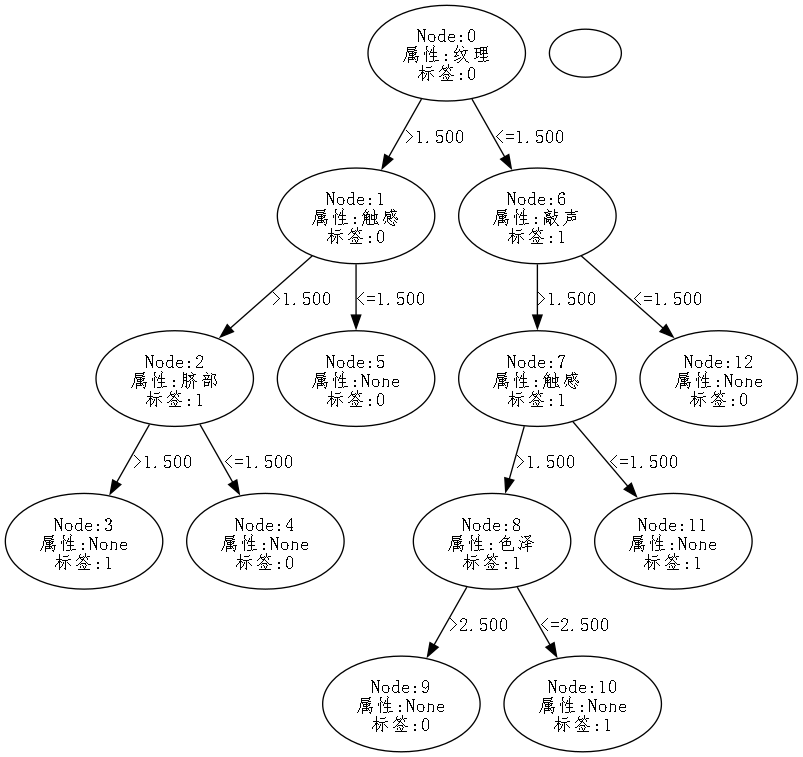

In [ ]:
tr = DTree_binary(method ='C4.5',prune = None, epsilon=0)
tree  = tr.fit(train_data=train_data,valid_data =valid_data)
draw(tree)
# print(tree)

### Scikit-learn实例

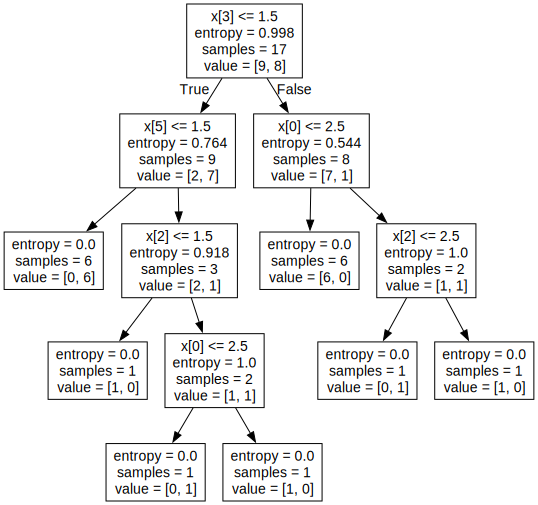

In [ ]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz
from sklearn import tree
# X_train = df.iloc[:,:-1].values
# y_train = df.iloc[:,-1].values
X_train = train_data.iloc[:,:-1].values
y_train = train_data.iloc[:,-1].values
clf = DecisionTreeClassifier(criterion='entropy')
clf.fit(X_train, y_train)
# tree.plot_tree(clf)

tree_pic = export_graphviz(clf, out_file="mytree.pdf")
with open('mytree.pdf') as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

使用Iris数据集，我们可以构建如下树：

In [ ]:
# data
def create_data():
    iris = load_iris()
    df = pd.DataFrame(iris.data, columns=iris.feature_names)
    df['label'] = iris.target
    df.columns = [
        'sepal length', 'sepal width', 'petal length', 'petal width', 'label'
    ]
    data = np.array(df.iloc[:100, [0, 1, -1]])
    # print(data)
    return data[:, :2], data[:, -1],iris.feature_names[0:2]


X, y,feature_name= create_data()


In [ ]:
X_train = train_data.iloc[:,:-1].values
y_train = train_data.iloc[:,-1].values

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

### 决策树分类

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz
from sklearn import tree

clf = DecisionTreeClassifier(criterion='entropy')
clf.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy')

一旦经过训练，就可以用 plot_tree函数绘制树：

[Text(0.4444444444444444, 0.9, 'x[3] <= 1.5\nentropy = 0.998\nsamples = 17\nvalue = [9, 8]'),
 Text(0.2222222222222222, 0.7, 'x[5] <= 1.5\nentropy = 0.764\nsamples = 9\nvalue = [2, 7]'),
 Text(0.1111111111111111, 0.5, 'entropy = 0.0\nsamples = 6\nvalue = [0, 6]'),
 Text(0.3333333333333333, 0.5, 'x[1] <= 2.0\nentropy = 0.918\nsamples = 3\nvalue = [2, 1]'),
 Text(0.2222222222222222, 0.3, 'x[0] <= 2.5\nentropy = 1.0\nsamples = 2\nvalue = [1, 1]'),
 Text(0.1111111111111111, 0.1, 'entropy = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(0.3333333333333333, 0.1, 'entropy = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(0.4444444444444444, 0.3, 'entropy = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(0.6666666666666666, 0.7, 'x[5] <= 1.5\nentropy = 0.544\nsamples = 8\nvalue = [7, 1]'),
 Text(0.5555555555555556, 0.5, 'entropy = 0.0\nsamples = 6\nvalue = [6, 0]'),
 Text(0.7777777777777778, 0.5, 'x[0] <= 2.0\nentropy = 1.0\nsamples = 2\nvalue = [1, 1]'),
 Text(0.6666666666666666, 0.3, 'entropy = 0.0\nsamples 

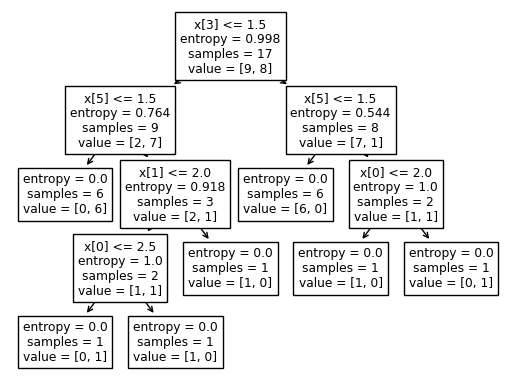

In [ ]:
tree.plot_tree(clf)

也可以导出树

### 决策树回归

In [ ]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt

In [ ]:
# Create a random dataset
rng = np.random.RandomState(1)
X = np.sort(5 * rng.rand(80, 1), axis=0)
y = np.sin(X).ravel()
y[::5] += 3 * (0.5 - rng.rand(16))

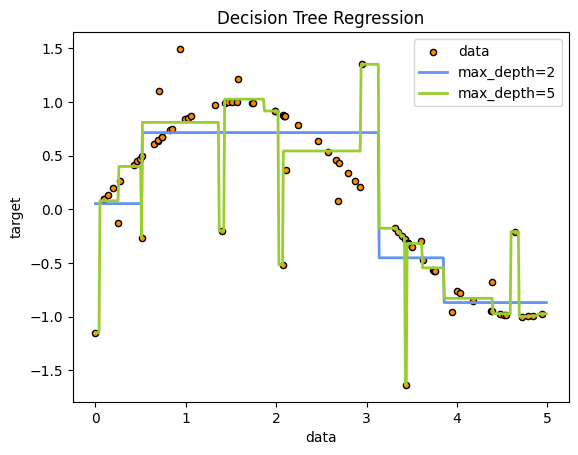

In [ ]:
# Fit regression model
regr_1 = DecisionTreeRegressor(max_depth=2)
regr_2 = DecisionTreeRegressor(max_depth=5)
regr_1.fit(X, y)
regr_2.fit(X, y)

# Predict
X_test = np.arange(0.0, 5.0, 0.01)[:, np.newaxis]
y_1 = regr_1.predict(X_test)
y_2 = regr_2.predict(X_test)

# Plot the results
plt.figure()
plt.scatter(X, y, s=20, edgecolor="black", c="darkorange", label="data")
plt.plot(X_test, y_1, color="cornflowerblue", label="max_depth=2", linewidth=2)
plt.plot(X_test, y_2, color="yellowgreen", label="max_depth=5", linewidth=2)
plt.xlabel("data")
plt.ylabel("target")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()

### Scikit-learn 的决策树参数

### 决策树调参

In [ ]:
# 导入库
from sklearn.tree import DecisionTreeClassifier
from sklearn import datasets
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics

In [ ]:
# 导入数据集
X = datasets.load_iris()  # 以全部字典形式返回,有data,target,target_names三个键
data = X.data
target = X.target
name = X.target_names
x, y = datasets.load_iris(return_X_y=True)  # 能一次性取前2个
print(x.shape, y.shape)

(150, 4) (150,)


In [ ]:
# 数据分为训练集和测试集
x_train, x_test, y_train, y_test = train_test_split(x,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=100)

In [ ]:
# 用GridSearchCV寻找最优参数（字典）
param = {
    'criterion': ['gini'],
    'max_depth': [30, 50, 60, 100],
    'min_samples_leaf': [2, 3, 5, 10],
    'min_impurity_decrease': [0.1, 0.2, 0.5]
}
grid = GridSearchCV(DecisionTreeClassifier(), param_grid=param, cv=6)
grid.fit(x_train, y_train)
print('最优分类器:', grid.best_params_, '最优分数:', grid.best_score_)  # 得到最优的参数和分值

最优分类器: {'criterion': 'gini', 'max_depth': 30, 'min_impurity_decrease': 0.1, 'min_samples_leaf': 10} 最优分数: 0.9416666666666665


### 参考

- https://github.com/fengdu78/lihang-code

- 李航. 统计学习方法[M]. 北京: 清华大学出版社,2019.

- https://scikit-learn.org